In [70]:
import torch
import numpy as np 
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [71]:
file_path = "/media/lars/F77E-7D07/"
unique_pairs = pd.read_csv(file_path + "unique_pairs.csv")

In [69]:
minimum = 10
len(unique_pairs[(unique_pairs["app_1_recommended"] >= minimum) & (unique_pairs["app_2_recommended"] >= minimum)])
unique_pairs = unique_pairs[(unique_pairs["app_1_recommended"] >= minimum) & (unique_pairs["app_2_recommended"] >= minimum)]

4649722

In [33]:
# Define sigmoid function for smooth transition
def compute_label(pmi, k=3):
        return 1 / (1 + np.exp(-k * (pmi + 12)))  # Smooth transition

# Apply the function
unique_pairs["label"] = unique_pairs["pmi"].apply(lambda p: compute_label(p, k=1))


In [34]:
unique_pairs = unique_pairs.reset_index(drop=True)

In [35]:
# Count occurrences of "True" label for each app_id_1 and app_id_2
true_counts = pd.concat([
    unique_pairs.loc[unique_pairs["label"] > 0.75, "app_id_1"],
    unique_pairs.loc[unique_pairs["label"] > 0.75, "app_id_2"]
]).value_counts()

# Get app IDs that appear in at least 'n' rows where label is True
valid_apps = set(true_counts[true_counts >= 1].index)

# Filter the DataFrame to keep only rows where either app_id_1 or app_id_2 is in valid_apps
filtered_df = unique_pairs[
    unique_pairs["app_id_1"].isin(valid_apps) & unique_pairs["app_id_2"].isin(valid_apps)
]

In [36]:
print(len(valid_apps), len(filtered_df))

3002 4504498


In [37]:
#unique_pairs = filtered_df

In [38]:
games = pd.concat([
    unique_pairs[['app_id_1', 'title_1']].rename(columns={'app_id_1': 'app_id', 'title_1': 'title'}),
    unique_pairs[['app_id_2', 'title_2']].rename(columns={'app_id_2': 'app_id', 'title_2': 'title'})
])

# Drop duplicates to get unique games
games = games.drop_duplicates().reset_index(drop=True)

games


,app_id,title
0,13500,Prince of Persia: Warrior Within™
1,113020,Monaco: What's Yours Is Mine
2,226560,Escape Dead Island
3,250180,METAL SLUG 3
4,253980,Enclave
...,...,...
3045,1599660,Sackboy™: A Big Adventure
3046,250900,The Binding of Isaac: Rebirth
3047,920210,LEGO® Star Wars™: The Skywalker Saga
3048,1361510,Teenage Mutant Ninja Turtles: Shredder's Revenge


In [39]:
unique_pairs = unique_pairs.drop(["title_1", "title_2"],axis=1)

In [40]:
le.fit(games["app_id"])
le.transform(games["app_id"])

array([  75,  220,  319, ..., 1742, 2447, 3049])

In [41]:
games_1 = pd.DataFrame(le.transform(unique_pairs["app_id_1"]))
games_2 = pd.DataFrame(le.transform(unique_pairs["app_id_2"]))
labels = unique_pairs["label"]

In [42]:
games.to_csv(file_path + "games_network.csv", index=False)
unique_pairs.to_csv(file_path + "unique_pairs_network.csv", index=False)
games_1.to_csv(file_path + "games_1.csv", index=False)
games_2.to_csv(file_path + "games_2.csv", index=False)
labels.to_csv(file_path + "labels.csv", index=False)

In [43]:
# Define the neural network with an embedding layer
class SiameseNN(nn.Module):
    def __init__(self, num_embeddings):
        super(SiameseNN, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings, 64)
    
    def forward_one(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)  # Flatten the embedding output
        output = x
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2
    
    def get_distance(self, input1, input2):
        return F.pairwise_distance(input1, input2, keepdim=True)
    
    def get_embedding(self, x):
        return self.forward_one(x)
    
    

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=10.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        x = F.pairwise_distance(output1, output2, keepdim=True)
        l = 2 * label - 1
        f = torch.max(l * x, l * (x-self.margin))
        loss_contrastive = torch.mean(torch.pow(torch.clamp(f, min=0.0), 2))

        #loss_contrastive = torch.mean(label * torch.pow(euclidean_distance, 2)+ \
        #                              (1-label) * torch.pow(torch.clamp((self.margin - euclidean_distance), min=0.0), 2))
        """ loss_contrastive = torch.where(
        margins > 10, 
        torch.pow(euclidean_distance - margins, 2), 
        torch.pow(euclidean_distance - 0, 2)
        ).mean() """

        return loss_contrastive

In [44]:
games_1 = pd.read_csv(file_path + "games_1.csv")
games_2 = pd.read_csv(file_path + "games_2.csv")
labels = pd.read_csv(file_path + "labels.csv")
games = pd.read_csv(file_path + "games_network.csv")
unique_pairs = pd.read_csv(file_path + "unique_pairs_network.csv")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Read all data and send to GPU
games_1_tensor = torch.tensor(games_1.values, dtype=torch.long).to(device)
games_2_tensor = torch.tensor(games_2.values, dtype=torch.long).to(device)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32).view(-1, 1).to(device)
games_le = pd.DataFrame(le.fit_transform(games["app_id"]))
games_le_tensor = torch.tensor(games_le.values, dtype=torch.long).to(device)

# Initialize the network, loss function and optimizer
num_embeddings = len(games_le)
model = SiameseNN(num_embeddings).to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

""" # Load the saved state dictionary
state_dict = torch.load("siamese_nn.pth")

# Apply the state dictionary to the model
model.load_state_dict(state_dict) """

Using device: cuda


' # Load the saved state dictionary\nstate_dict = torch.load("siamese_nn.pth")\n\n# Apply the state dictionary to the model\nmodel.load_state_dict(state_dict) '

In [55]:
import time

total_time = 5 * 60
print_time = 10
gpu_size = 40000


recommendations = unique_pairs["common_ratio"]
#recommendations = unique_pairs["common_recommended"] + unique_pairs["app_1_recommended"] + unique_pairs["app_2_recommended"]

start_time = time.time()
print_start = time.time()
num_epochs = 0
losses = 0
last_loss = 1
length = len(unique_pairs)

while time.time() - start_time < total_time:

    if num_epochs % 10 == 0:
        sample_weights = recommendations
        sample_weights /= sample_weights.sum()
        sampled_indices = np.random.choice(unique_pairs.index, size=gpu_size, p=sample_weights)

        sampled_games_1 = games_1_tensor[sampled_indices]
        sampled_games_2 = games_2_tensor[sampled_indices]
        sampled_labels = labels_tensor[sampled_indices]

    optimizer.zero_grad()
    output_1, output_2 = model.forward(sampled_games_1, sampled_games_2)
    loss = criterion.forward(output_1, output_2, sampled_labels)
    loss.backward()
    optimizer.step()
    
    losses += loss.item()

    if print_time < (time.time() - print_start):
        print(f'Time elapsed: {int((time.time() - print_start))}s, {num_epochs} epochs, Percentage lost: {((last_loss - (losses / num_epochs)) / last_loss) * 100:.8f}, Loss: {losses / num_epochs:.8f}')

        last_loss = losses / num_epochs
        losses = 0
        print_start = time.time()
        torch.save(model.state_dict(), "siamese_nn.pth")
        num_epochs = 0

    num_epochs += 1

torch.save(model.state_dict(), "siamese_nn.pth")

Time elapsed: 10s, 780 epochs, Percentage lost: -172.32834996, Loss: 2.72328350
Time elapsed: 10s, 799 epochs, Percentage lost: 4.27213891, Loss: 2.60694105
Time elapsed: 10s, 794 epochs, Percentage lost: 0.94990776, Loss: 2.58217751
Time elapsed: 10s, 800 epochs, Percentage lost: 0.45552721, Loss: 2.57041499
Time elapsed: 10s, 800 epochs, Percentage lost: 0.17967572, Loss: 2.56579658
Time elapsed: 10s, 792 epochs, Percentage lost: 0.15093481, Loss: 2.56192390
Time elapsed: 10s, 800 epochs, Percentage lost: 0.16916409, Loss: 2.55759004
Time elapsed: 10s, 800 epochs, Percentage lost: 0.15439512, Loss: 2.55364125
Time elapsed: 10s, 794 epochs, Percentage lost: -0.11484196, Loss: 2.55657390
Time elapsed: 10s, 800 epochs, Percentage lost: 0.22795197, Loss: 2.55074614
Time elapsed: 10s, 790 epochs, Percentage lost: 0.03889836, Loss: 2.54975394
Time elapsed: 10s, 800 epochs, Percentage lost: -0.03374377, Loss: 2.55061432
Time elapsed: 10s, 793 epochs, Percentage lost: 0.10015605, Loss: 2.548

In [56]:
torch.save(model.state_dict(), "siamese_nn.pth")

In [57]:
model.eval()

with torch.no_grad():
    embeddings = model.get_embedding(games_le_tensor)

model.train()

games["location"] = list(embeddings.cpu().detach().numpy())
locations_array = np.array(games["location"].tolist())


In [58]:
# Reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
games["location_2d"] = list(tsne.fit_transform(locations_array))

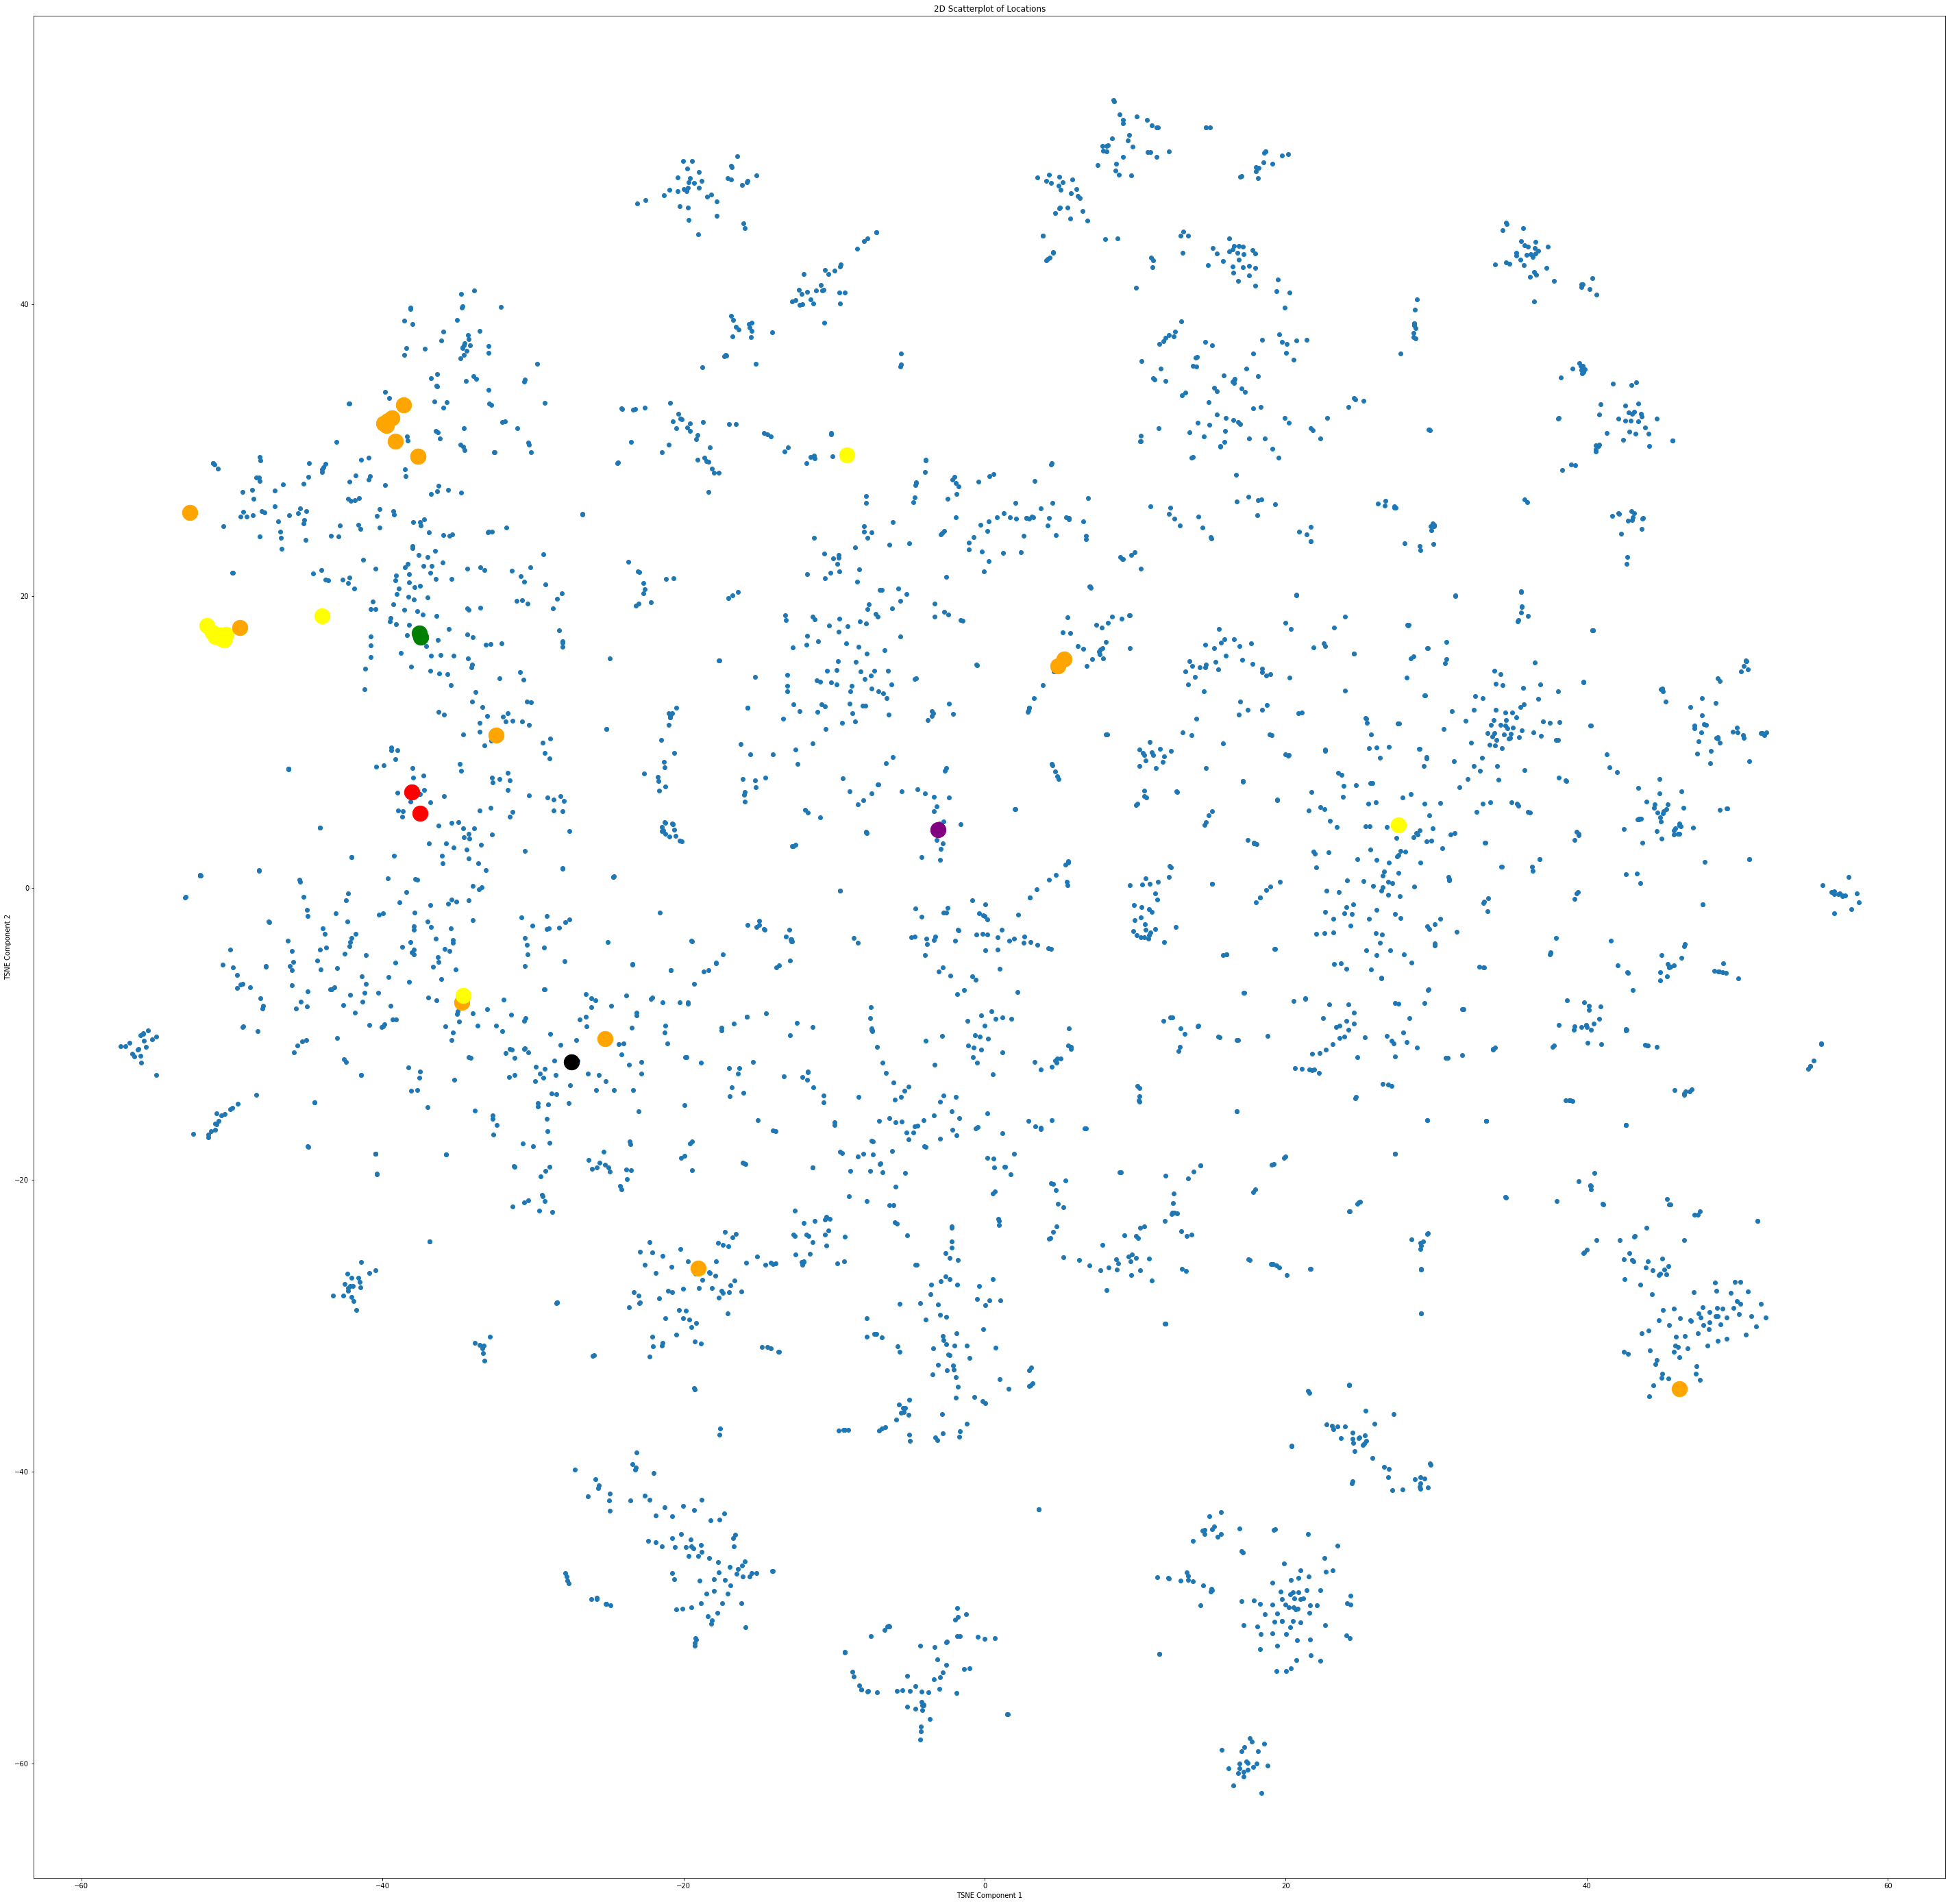

In [59]:
plt.figure(figsize=(50, 50))
plt.scatter(games["location_2d"].apply(lambda x: x[0]), games["location_2d"].apply(lambda x: x[1]))

""" for i, row in games.iterrows():
    plt.text(row["location_2d"][0], row["location_2d"][1], str(row["title"]), fontsize=9) """


for i, row in games.iterrows():
    if str(row["title"]) == "shapez":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='purple', s=500)  # Larger and purple dot
    if str(row["title"]) == "Factorio":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='black', s=500)  # Larger and black dot
    if str(row["title"]) == "Portal":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='red', s=500)  # Larger and red dot
    if str(row["title"]) == "Portal 2":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='red', s=500)  # Larger and red dot
    if str(row["title"]) == "Metro 2033 Redux":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='green', s=500)  # Larger and green dot
    if str(row["title"]) == "Metro: Last Light Redux":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='green', s=500)  # Larger and green dot
    if str(row["title"]) in list(games[games["title"].str.startswith("LEGO", na=False)]["title"]):
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='yellow', s=500)  # Larger and yellow dot
    if str(row["title"]) in list(games[games["title"].str.startswith("STAR WARS", na=False)]["title"]):
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='orange', s=500)  # Larger and orange dot

""" for i, row in games.iterrows():
    if row["app_id"] in result:
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='purple', s=500)  # Larger and purple dot
    if str(row["title"]) == "Factorio":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='yellow', s=500)  # Larger and purple dot """

plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("2D Scatterplot of Locations")
plt.show()

In [60]:
games.to_csv("filtered_archive/games_locations.csv")

In [65]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Convert the column of lists into a 2D NumPy array
location_data = np.vstack(games["location"])

kmeans = KMeans(n_clusters=20)
kmeans.fit(location_data)

scaler = StandardScaler()
scaler.fit(location_data)
X_scaled = scaler.transform(location_data)

dbscan = DBSCAN(eps=1, min_samples=2)
clusters = dbscan.fit_predict(X_scaled)

In [66]:
games["cluster"] = kmeans.labels_
games["cluster_2"] = clusters + 1

In [67]:
games["cluster_2"].nunique()

155

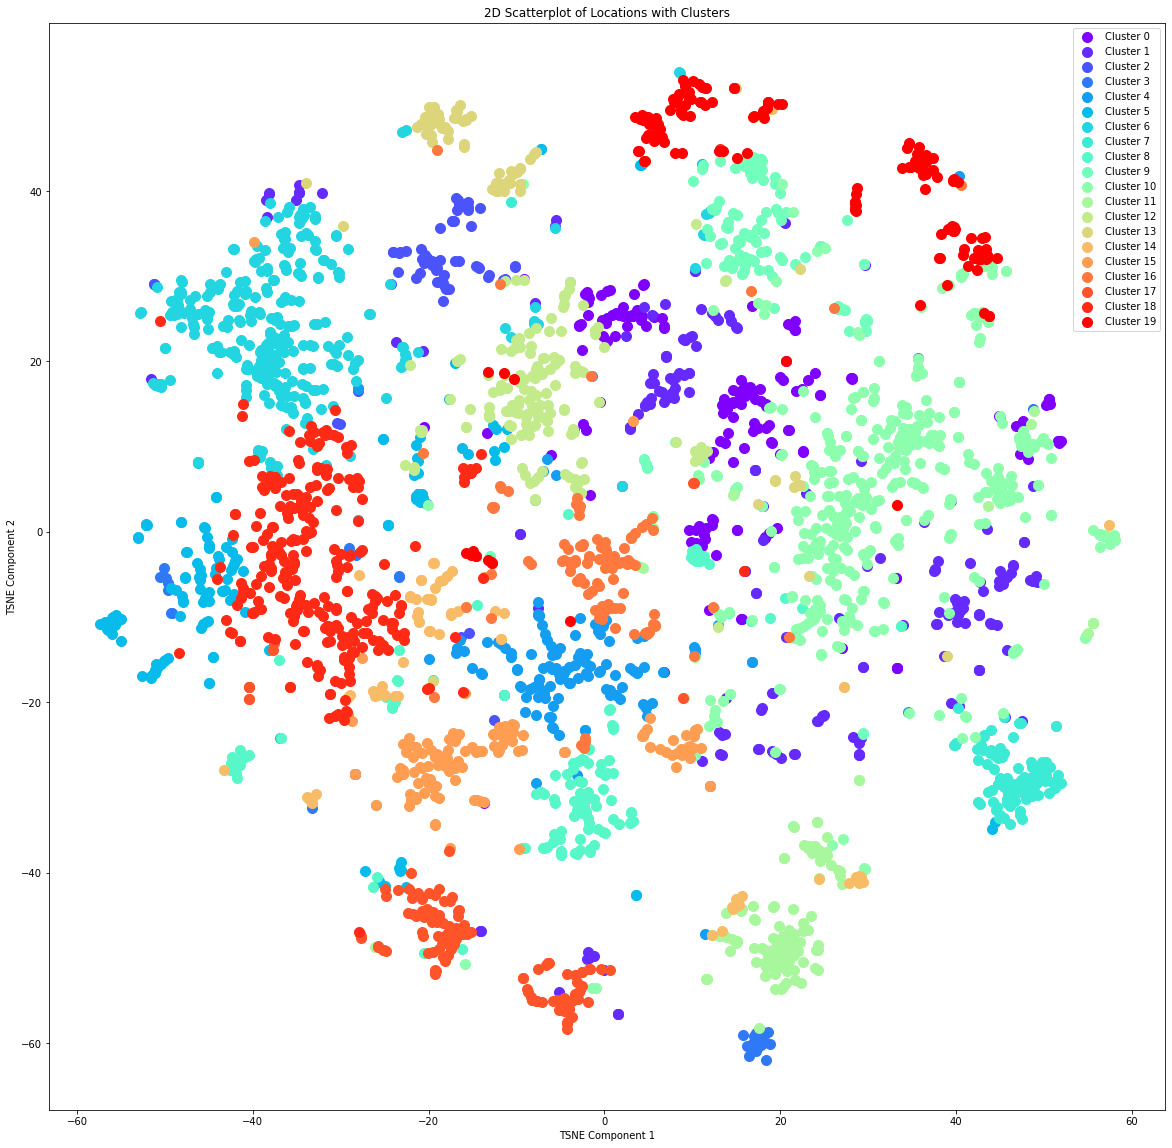

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a colormap for clusters
num_clusters = games["cluster"].nunique()
cmap = plt.cm.get_cmap("rainbow", num_clusters)  # Or use "viridis", "rainbow", etc.
colors = [cmap(i / num_clusters) for i in range(num_clusters)]


plt.figure(figsize=(20, 20))  # Adjust figure size as needed

# Scatter plot with unique colors per cluster
for cluster in range(num_clusters):
    cluster_data = games[games["cluster"] == cluster]
    plt.scatter(
        cluster_data["location_2d"].apply(lambda x: x[0]),
        cluster_data["location_2d"].apply(lambda x: x[1]),
        color=colors[cluster],
        label=f"Cluster {cluster}",
        s=100  # Adjust size as needed
    )


# Labels and title
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("2D Scatterplot of Locations with Clusters")
plt.legend()
plt.show()
